# Application for Univariate Time Series: Algorithmic Trading Model for $/₺ Exchange Rates

- <b>Univariate Time Series: ARIMA<b>

In [1]:
import warnings 
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yahoofinancials as yf
import requests
import ftplib
import io

<b>Let's download the Dataset from Yahoo Finance<b>

In [2]:
history = yf.YahooFinancials('USDTRY=X').get_historical_price_data('2017-01-01', '2020-12-31', 'daily')

df = pd.DataFrame(history['USDTRY=X']['prices'])

df = df.drop(['date'], axis=1)
df["formatted_date"] = pd.to_datetime(df['formatted_date'])
df = df.set_index('formatted_date')
df.head()

,high,low,open,close,volume,adjclose
formatted_date,,,,,,
2017-01-02,3.54485,3.52440,3.53490,3.53490,0.0,3.53490
2017-01-03,3.60310,3.53529,3.54280,3.54190,0.0,3.54190
2017-01-04,3.59310,3.56700,3.59115,3.59230,0.0,3.59230
2017-01-05,3.63486,3.55536,3.56930,3.56937,0.0,3.56937
2017-01-06,3.63600,3.59137,3.59270,3.59191,0.0,3.59191


<b>We draw the 3-year $/₺ rate from Yahoo Finanace, covering the trading days between 01-01-2017 and 12-31-2020. In the data set, we record the daily opening rate, also called OHLC, intraday high and low exchange rates, and closing rate data as Pandas dataframe. Let's create a new series by taking the differences between the closing rates. This is essentially a one-day trading return. We should pay attention to two things about this variable, which we call "Return", that is, return: 1) Return cannot be calculated for the first trading day in the data set. Because Return is the exchange rate change between the previous day and that trading day. Therefore, it will write Nan (not available - non available) in the Return cell corresponding to the first trading day. 2) We actually obtained the Return variable by applying the difference stationary process to the Close (Close price) series.<b>

<b>Let's create the "return" variable by taking the closing exchange rate difference.<b>

In [3]:
df["returns"] = df["close"].diff()

- <b>Grapp : Closing Price and Return Rate Together<b>

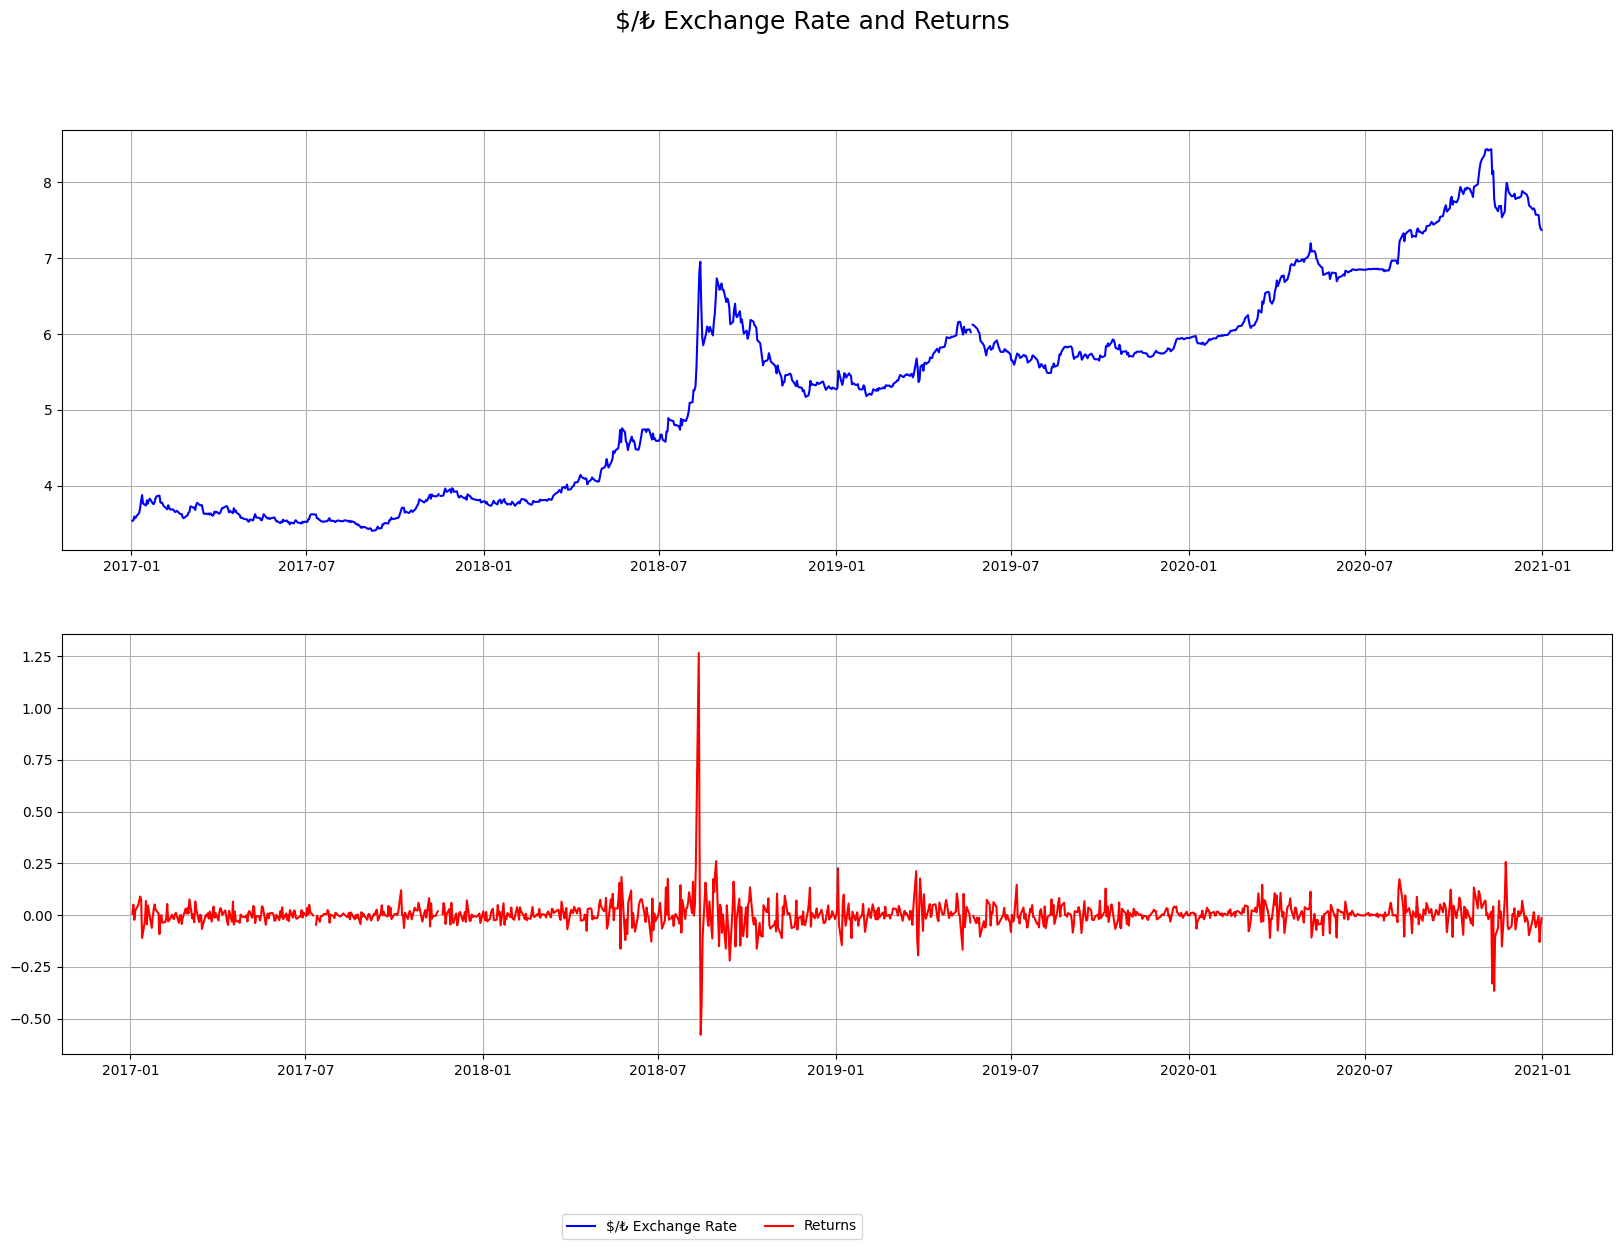

In [4]:
f = plt.figure(figsize=(20,12))
f.suptitle("$/₺ Exchange Rate and Returns", fontsize=18)
plt.subplot(211)
plt.plot(df["close"], color='blue')
plt.grid(True)
plt.subplot(212)
plt.plot(df["returns"], color='red')
f.legend(["$/₺ Exchange Rate", "Returns"], loc='lower center', ncol=2,bbox_to_anchor=(0.45, -0.05))
plt.grid(True)
plt.show()

<b>As can be seen from the graph, while the closing rate is a non-stationary series, it looks like a stationary series by taking the first difference. However, unit root tests should be used to be sure.<b>

<b>Total positive and negative returns over the period.<b>

In [5]:
print("Total positive returns: ", df[df["returns"] > 0].shape[0])
print("Total negative returns: ", df[df["returns"] < 0].shape[0])

Total positive returns:  557
Total negative returns:  479


<b>Basic Stats for Return

In [6]:
df["returns"].describe()

count    1037.000000
mean        0.003636
std         0.069808
min        -0.578400
25%        -0.020101
50%         0.002210
75%         0.026030
max         1.265800
Name: returns, dtype: float64

- <b>Anomaly and Outlier Detection<b>

In [7]:
len(df)

1044

<b>Interquantil Method

[<AxesSubplot: >]

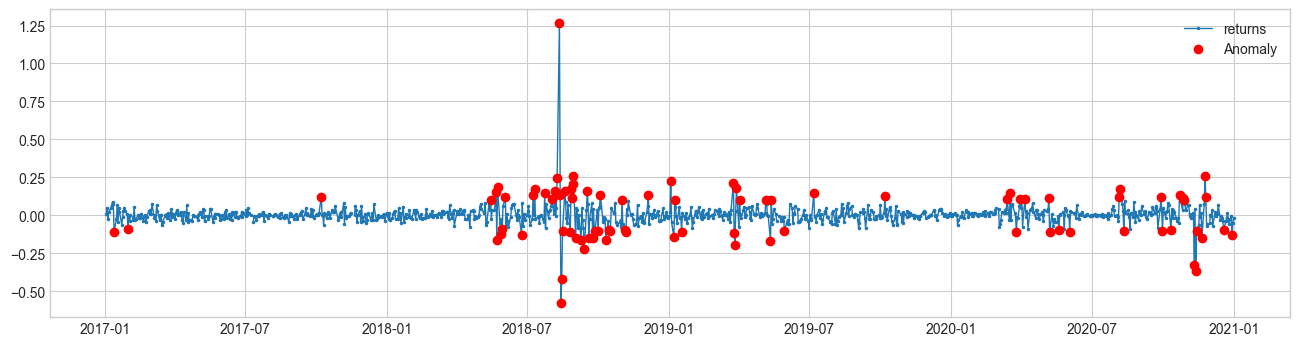

In [8]:
from adtk.detector import InterQuartileRangeAD

iqr = InterQuartileRangeAD(c=1.5) 

anomalies = iqr.fit_detect(df["returns"])

# Graphical representation
from adtk.visualization import plot
plot(df["returns"], anomaly=anomalies, ts_linewidth=1, ts_markersize=3,anomaly_color='red', anomaly_tag='marker', anomaly_markersize=6, anomaly_alpha=0.8)

<b>Drop Anomalies

In [9]:
not_outliers = anomalies != 1

df = df[not_outliers]

len(df)

959

<b>1) Are Series Stationary?<b>

- <b>Augmented Dickey-Fuller Test<b>

<b>2) Is Series Normal Distribution? <b>

- <b>auto-correlation<b>

<b>3) Is Series Normal Distribution?<b>

- <b>Graph Method<b>
- <b>Jarque-Bera test<b>

In [10]:
df.dropna(inplace=True)
len(df)

952

In [11]:
# Augmented Dickey-Fuller test (close)

from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(df["close"])

print("ADF Statistic: %f" % adf_result[0])
print("p-value: %f" % adf_result[1])

if adf_result[1] > 0.05:
    print("The series is not stationary")
else:
    print("The series is stationary")

ADF Statistic: -0.508461
p-value: 0.890355
The series is not stationary


In [12]:
# Augmented Dickey-Fuller test (return)

adf_result = adfuller(df["returns"])

print("ADF Statistic: %f" % adf_result[0])
print("p-value: %f" % adf_result[1])

if adf_result[1] > 0.05:
    print("The series is not stationary")
else:
    print("The series is stationary")

ADF Statistic: -29.024925
p-value: 0.000000
The series is stationary


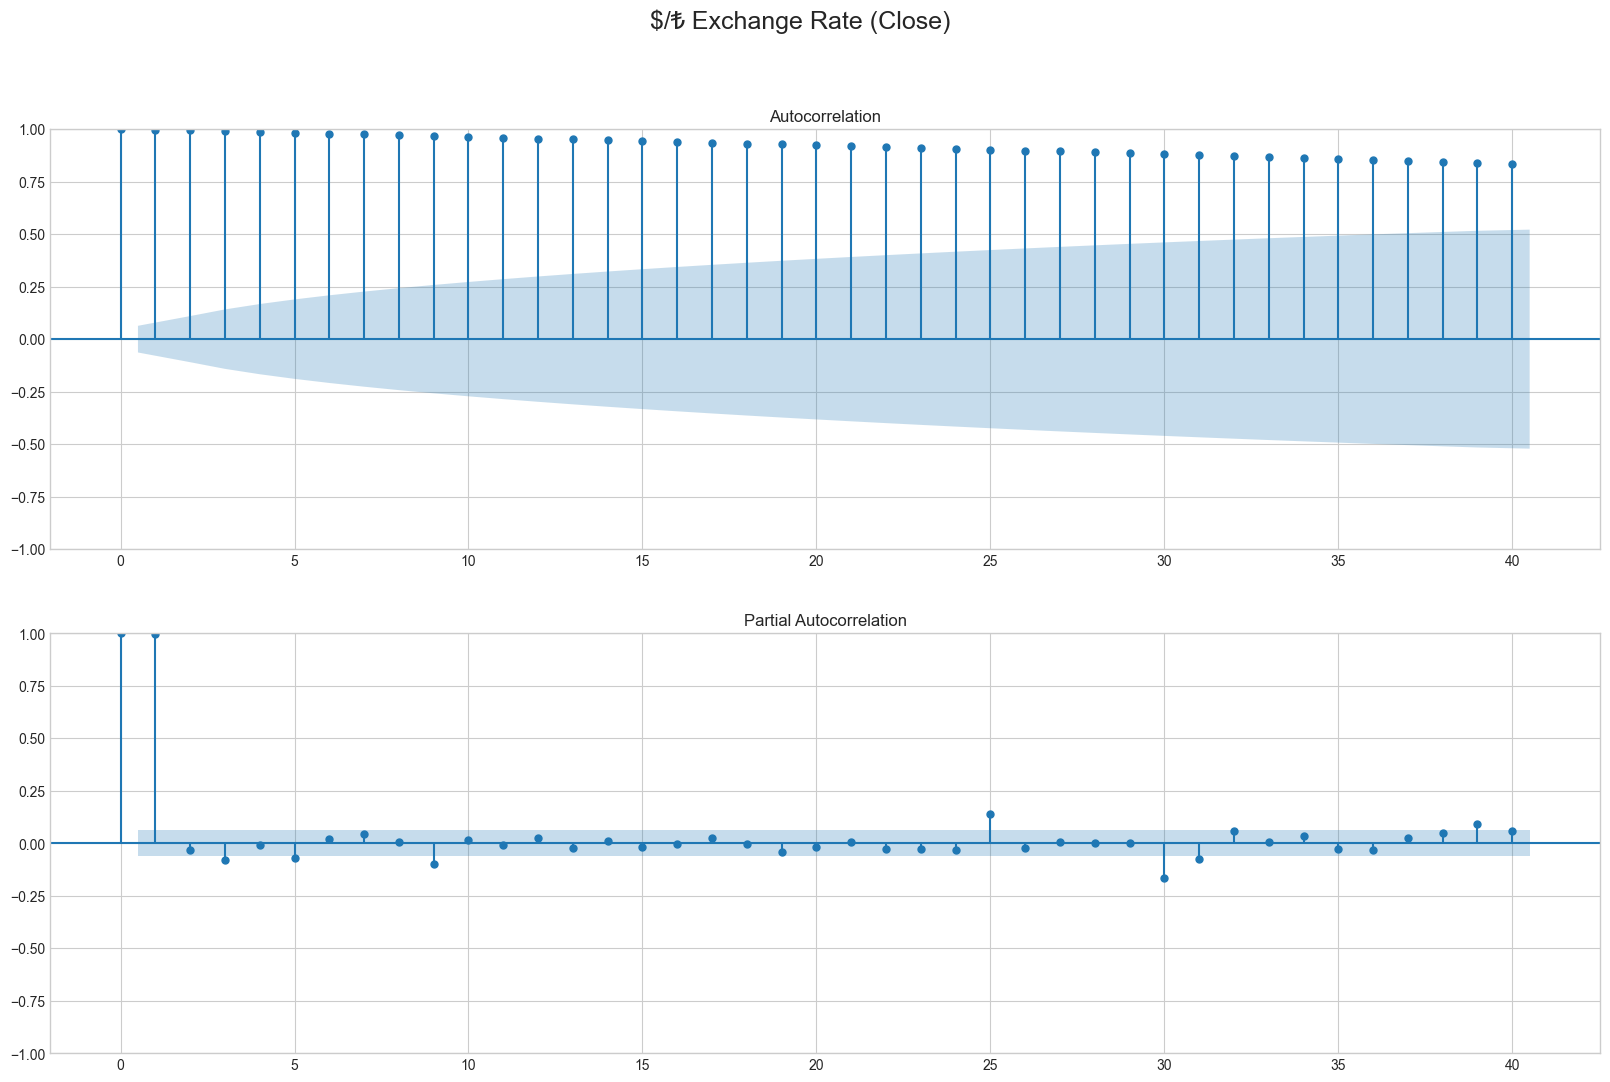

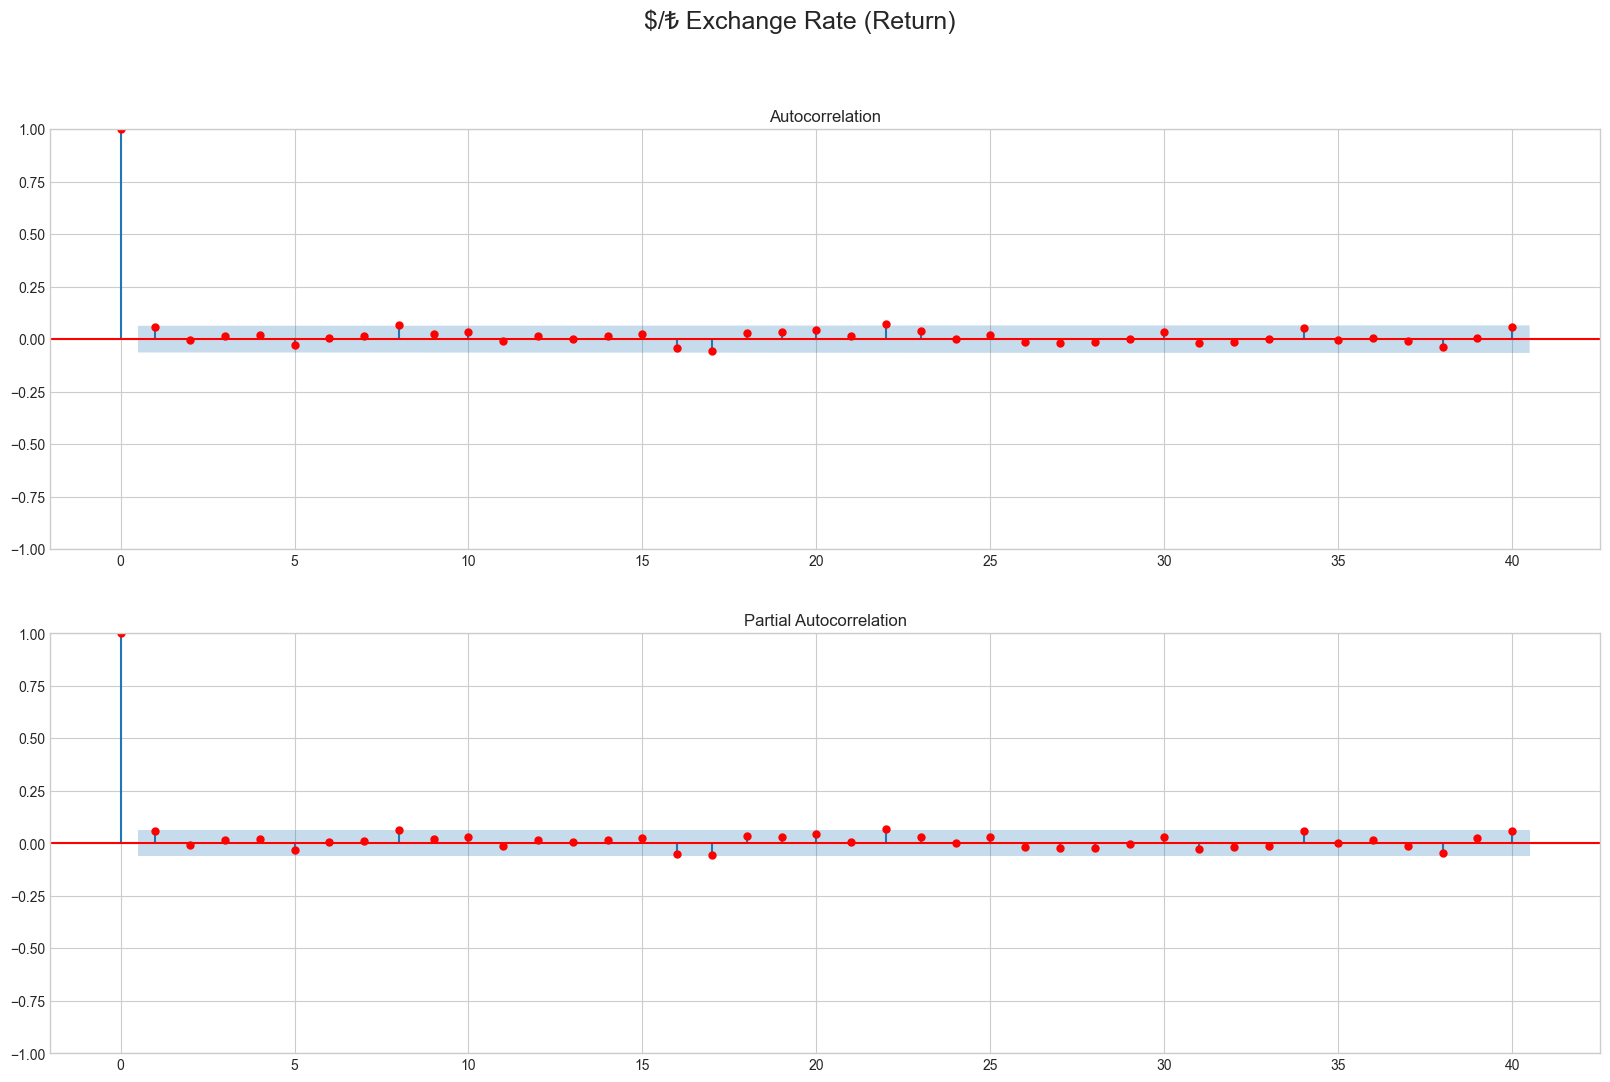

In [13]:
# auto-correlation and partial auto-correlation (close)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

f = plt.figure(figsize=(20,12))
f.suptitle("$/₺ Exchange Rate (Close)", fontsize=18)
ax1 = f.add_subplot(211)
fig = plot_acf(df["close"], lags=40, ax=ax1)
ax2 = f.add_subplot(212)
fig = plot_pacf(df["close"], lags=40, ax=ax2)

# auto-correlation and partial auto-correlation (return)

f = plt.figure(figsize=(20,12))
f.suptitle("$/₺ Exchange Rate (Return)", fontsize=18)
ax1 = f.add_subplot(211)
fig = plot_acf(df["returns"], lags=40, ax=ax1,color='red')
ax2 = f.add_subplot(212)
fig = plot_pacf(df["returns"], lags=40, ax=ax2,color='red')



stat : 51.150 , p : 0.000
Close series is not normally distributed
stat : 1.186 , p : 0.553
Return series is normally distributed


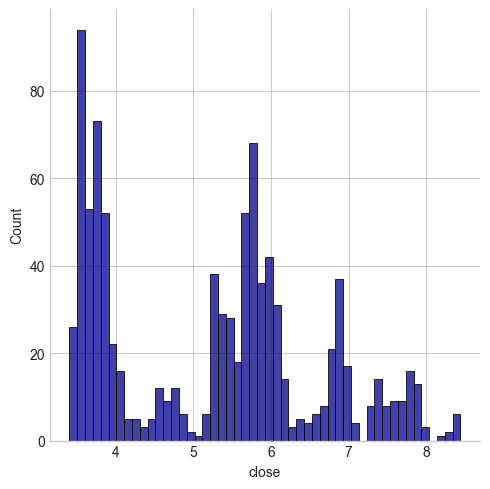

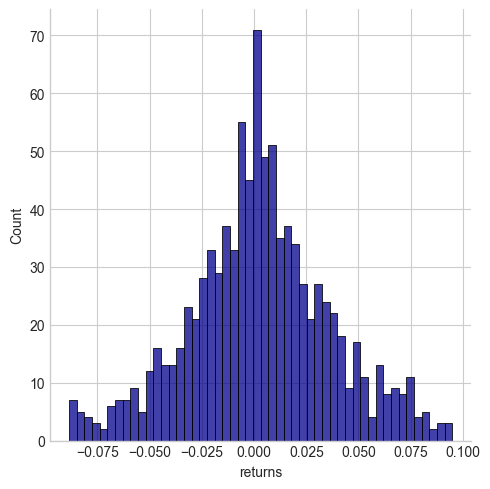

In [14]:
# Graph Method for auto-correlation

# close
sns.displot(df["close"],kind="hist",color='darkblue',bins=50,kde_kws={'linewidth': 4,'shade':True})

# return 
sns.displot(df["returns"],kind="hist",color='darkblue',bins=50,kde_kws={'linewidth': 4,'shade':True})

# Jarque-Bera test (close)

from scipy.stats import jarque_bera

stat,p = jarque_bera(df["close"])

print("stat : %.3f , p : %.3f" %(stat,p))

if p > 0.05:
    print("Close series is normally distributed")
else:
    print("Close series is not normally distributed")

# Jarque-Bera test (return)

stat,p = jarque_bera(df["returns"])

print("stat : %.3f , p : %.3f" %(stat,p))

if p > 0.05:
    print("Return series is normally distributed")

else:
    print("Return series is not normally distributed")




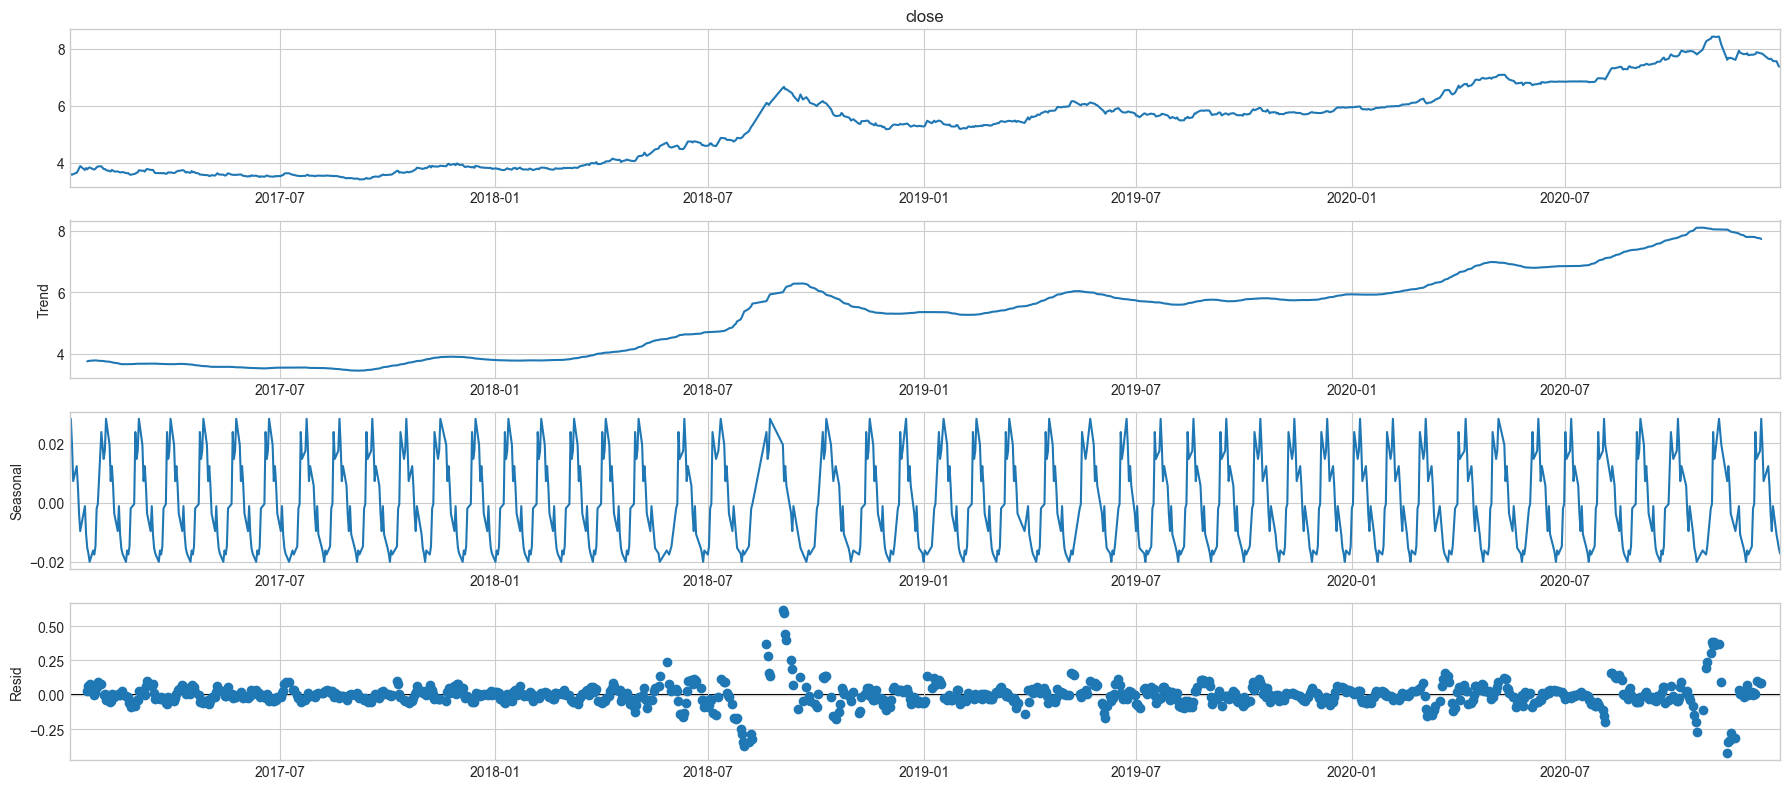

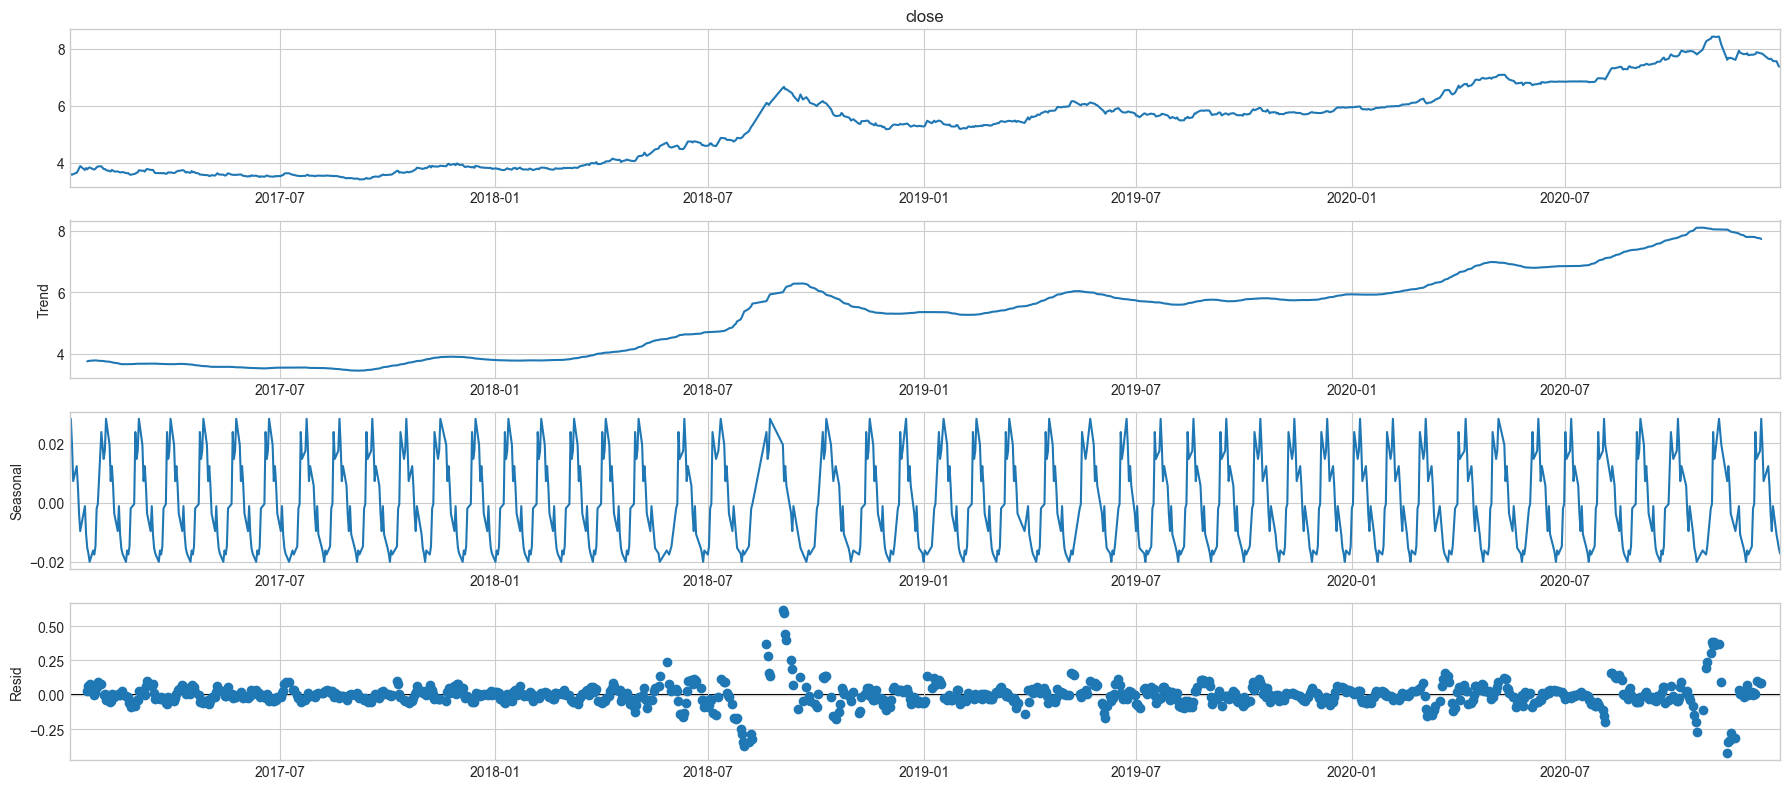

In [15]:
# Decomposition plot (close)

from pylab import rcParams

rcParams['figure.figsize'] = 18, 8

from statsmodels.tsa.seasonal import seasonal_decompose

sd_result = seasonal_decompose(df["close"], model='additive', period=20)

sd_result.plot()


<b>freq = 20 was chosen because there is data for 717 trading days. We need to divide these data into intervals of 717/36 months = 20 days to see if it has a monthly periodicity.<b>

<b>The first chart contains the time series itself.

The second graph is the Trend graph. The Close variable generally has an upward trend. The trend gives us a clue that an autoregressive process should be followed. That is, the value of the data at time t is correlated with its past values. Therefore, in order to estimate the value of the data at time t, It is necessary to include historical values in the model as explanatory or predictive.

The third graph shows the periodic change. It is clearly seen that there is a certain periodicity in the exchange rate.

The fourth graph contains residuals representing the error component, also called "white noise". Here we can see how random and unpredictable the movements in the time series are.<b>

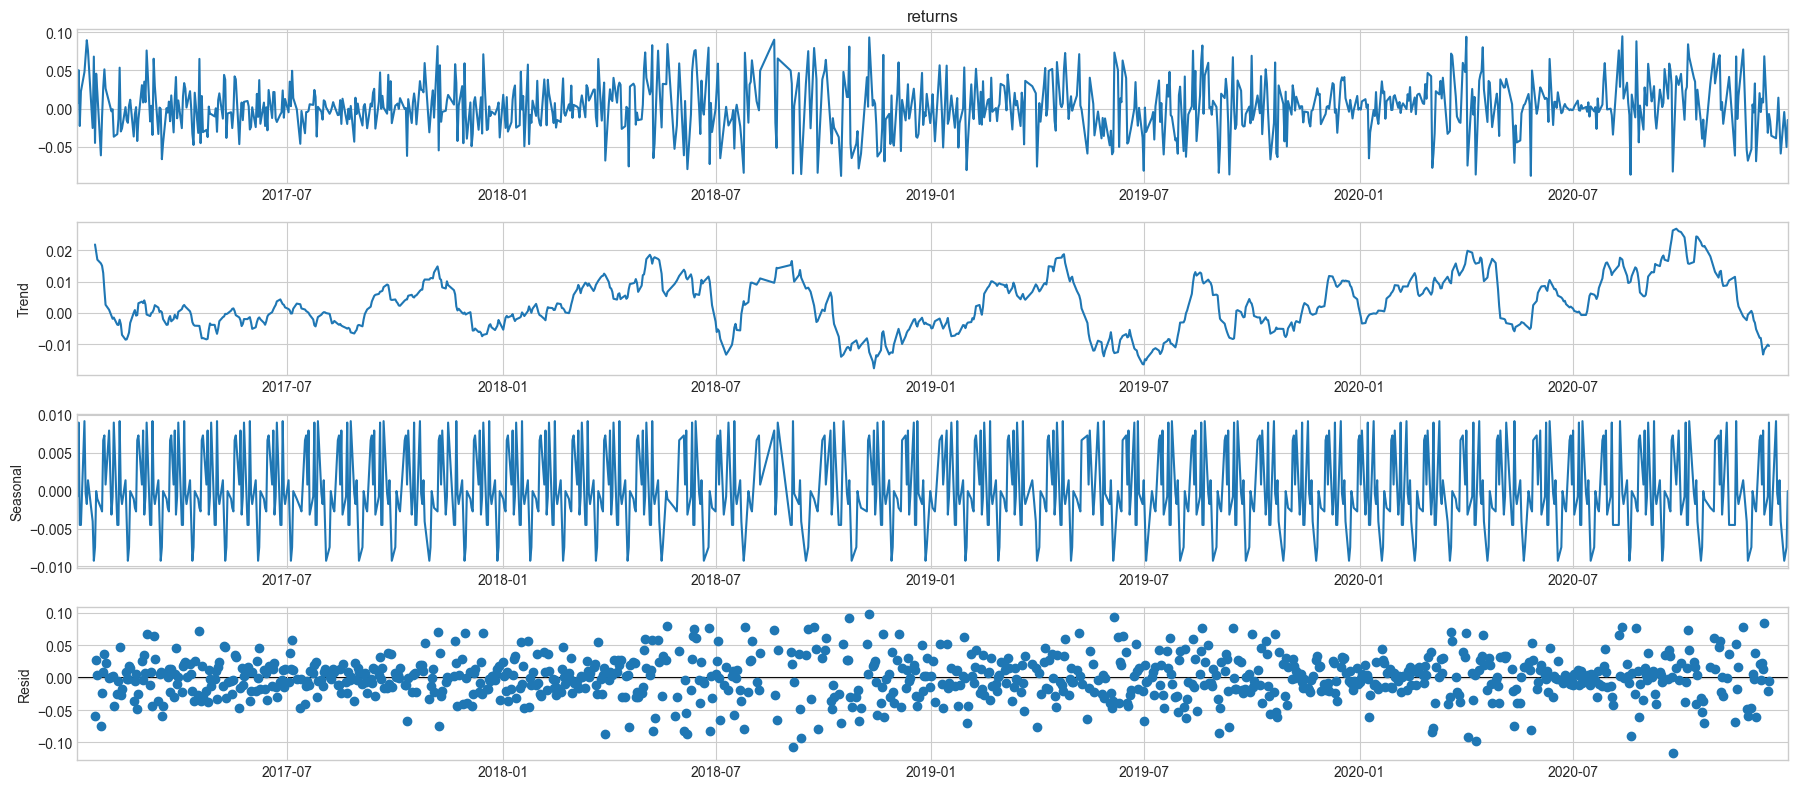

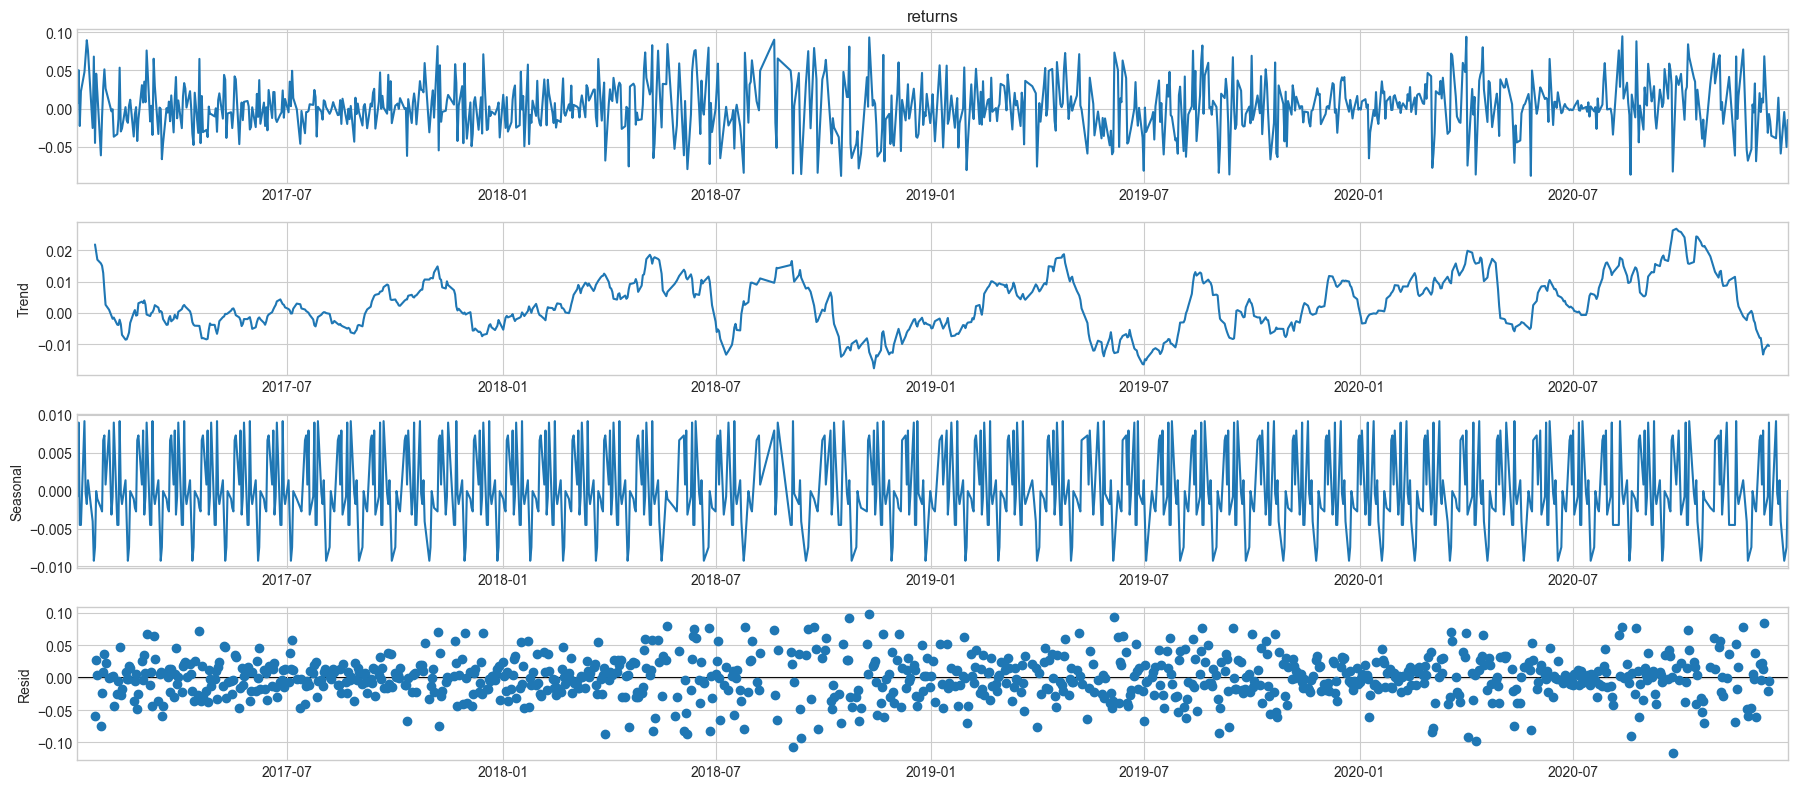

In [16]:
# DECEMPOSITION PLOT (RETURN)

sd_result = seasonal_decompose(df["returns"], model='additive', period=20)

sd_result.plot()

<b>Grid Search for ARIMA<b>

In [17]:
import pmdarima as pm

model = pm.auto_arima(df["close"], start_p=0, start_q=0,trace=True)

model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2639.766, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2642.562, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2642.286, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2637.525, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-2641.358, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2644.203, Time=0.35 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-2642.209, Time=0.81 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2639.108, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-2641.085, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-2642.982, Time=0.82 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-2643.568, Time=0.22 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 3.032 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  952
Model:               SARIMAX(1, 1, 1)   Log Likelihood                1326.102
Date:                Tue, 24 Jan 2023   AIC                          -2644.203
Time:                        15:52:21   BIC                          -2624.773
Sample:                             0   HQIC                         -2636.801
                                - 952                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0010      0.001      1.140      0.254      -0.001       0.003
ar.L1          0.7416      0.075      9.881      0.000       0.594       0.889
ma.L1         -0.6779      0.084     -8.116      0.000      -0.842      -0.514
sigma2         0.0036   4.95e-05     72.735      0.000       0.004       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             74219.69
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               4.13   Skew:                             2.63
Prob(H) (two-sided):                  0.00   Kurtosis:                        45.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<b>Attention! Normally, we had to use the stationary Return series. However, we used the non-stationary Close series here. While the auto_arima function was creating the appropriate ARIMA ordering values, it made it stationary by applying a difference stationary process to the Close series.<b>

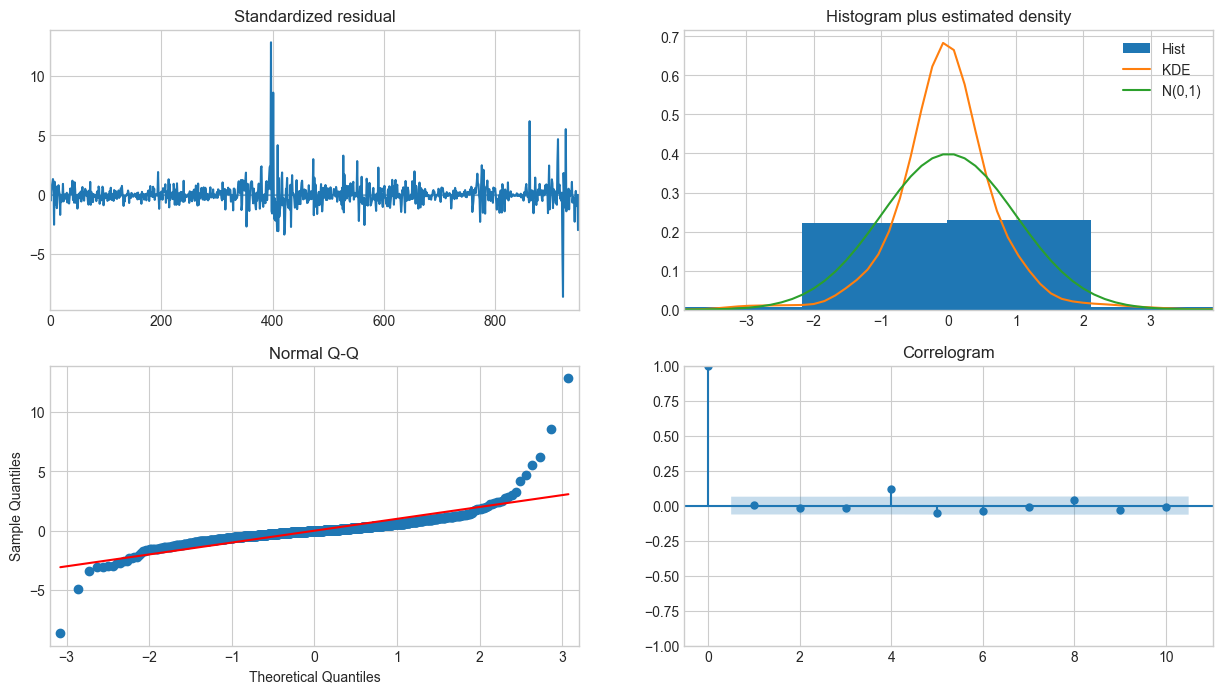

In [18]:
model.plot_diagnostics(figsize=(15,8))

plt.show()

<b>What do the graphs say about the residuals?<b>
- <b>1. graph (standardized residual), are the residuals stable?<b>
- <b>Chart 2 (Histogram plus estimated density)<b>
- <b>Chart 3 (Normal Q-Q), do the residuals have a normal distribution?<b>
- <b>Chart 3 (Correlogram), is there any autocorrelation in the residuals?<b>

<b>As can be seen, the residuals are stationary, but although most of the data have a normal distribution, they do not have a normal distribution as a whole. Finally, the residuals do not have an autocorrelation problem.<b>

# Let's test the model on real data

In [19]:
from yahoo_fin.stock_info import *

data = get_data("USDTRY=X", start_date="01-04-2021", end_date="01-31-2021", index_as_date = True)

data = data.drop(["open","high","low","adjclose","volume","ticker"], axis=1)

In [20]:
data

,close
2021-01-04,7.43342
2021-01-05,7.42150
2021-01-06,7.38379
2021-01-07,7.29972
2021-01-08,7.32660
2021-01-11,7.35765
2021-01-12,7.47195
2021-01-13,7.44696
2021-01-14,7.39427
2021-01-15,7.36610


In [21]:
n = len(data)

fc, confint = model.predict(n_periods=n, return_conf_int=True)

data["Predicted"] = fc

# RMSE

from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(data["close"], data["Predicted"])
)
print("RMSE: ", rmse)

RMSE:  0.056787060033128986


# Algorithmic Trading Model Approaches

<b>There are three basic approaches in algorithmic trading models.<b>
- <b>1) Signal approach<b>
- <b>2) Valuation approach<b>
- <b>3) Threshold approach<b>

<b>Generating Buy-Sell Signals<b>

<b>If the real exchange rate is greater than the predicted exchange rate, it means that the exchange rate is overvalued, that is, it will fall. Conversely, if the exchange rate is lower than the predicted exchange rate, it means that it is undervalued by the market, that is, it will rise. Now, let's create Buy-Sell signals according to this strategy.<b>

In [22]:
data["BUY"] = np.where(data["close"] < data["Predicted"], 1, 0)

data["SELL"] = np.where(data["close"] >= data["Predicted"], 1, 0)

# Trading Indicators

data["BUY_ind"] = np.where(data["BUY"] > data["BUY"].shift(1), 1, 0)

data["SELL_ind"] = np.where(data["SELL"] > data["SELL"].shift(1), 1, 0)

# Graph : Comparison of Actual and Predicted Exchange Rates

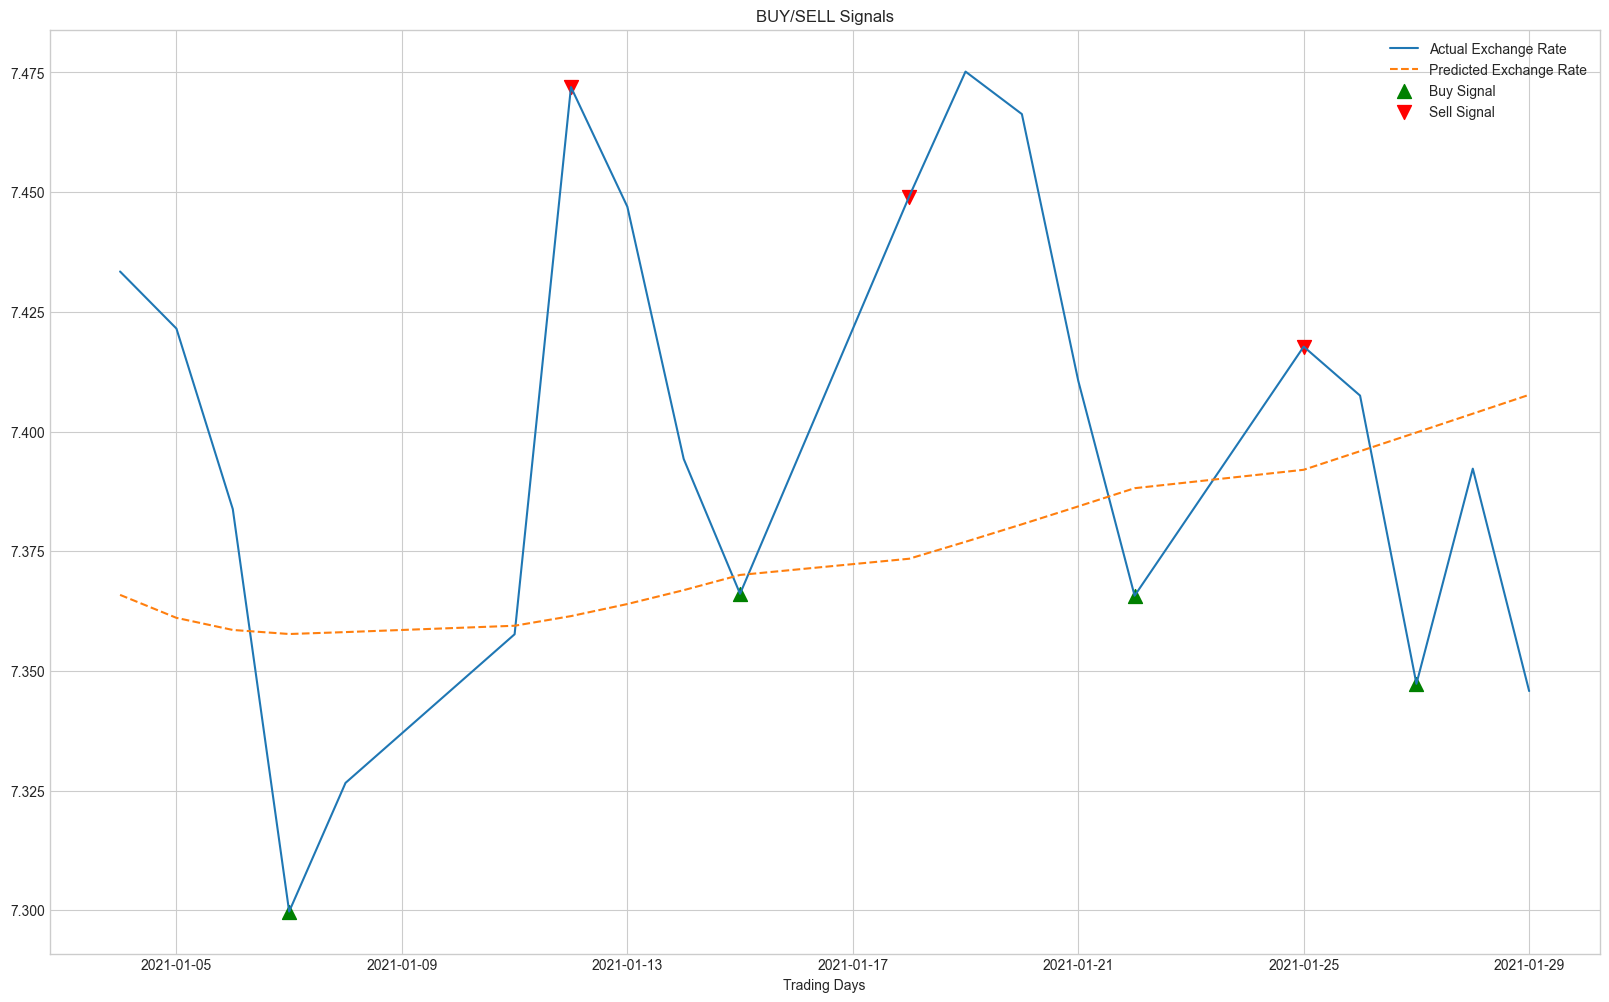

In [23]:
data["date"] = data.index

fig1 = plt.figure(figsize=(20,12))
plt.plot(data["close"], label="Actual Exchange Rate")
plt.plot(data["Predicted"], label="Predicted Exchange Rate",linestyle='--')

plt.scatter(data[data["BUY_ind"] == 1]["date"].values, 
            data[data["BUY_ind"] == 1]["close"].values,
            marker="^", color="green", label="Buy Signal", s=100)

plt.scatter(data[data["SELL_ind"] == 1]["date"].values,
            data[data["SELL_ind"] == 1]["close"].values,
            marker="v", color="red", label="Sell Signal", s=100)

plt.xlabel("Trading Days")
plt.legend(loc="best")
plt.title("BUY/SELL Signals")
plt.show()

<b>Now, let's both report and visualize what the algorithmic trading gain will be on the last trading day of January when trading is started with ₺1000 on January 5, 2021 at the beginning of the term.<b>

In [24]:
# Daily percent gain
data["Return_pct"] = data["close"].pct_change().shift(-1)

# Daily Value of 1000₺ Investment

data["Value"] = 1000*(1+(np.where(data["BUY"]==1,
                                 data["Return_pct"],0).cumsum()))

data["Value"] = data["Value"].shift(1) # Reflection of the return the next day

# Investment Status Report

print("==Investment Status Report=======================================")
print("₺1000 at the Beginning of the Term Became",data["Value"][-1].round(2),"₺ in",len(data),"Days")
print("=================================================================")

==Investment Status Report=======================================
₺1000 at the Beginning of the Term Became 1041.62 ₺ in 20 Days


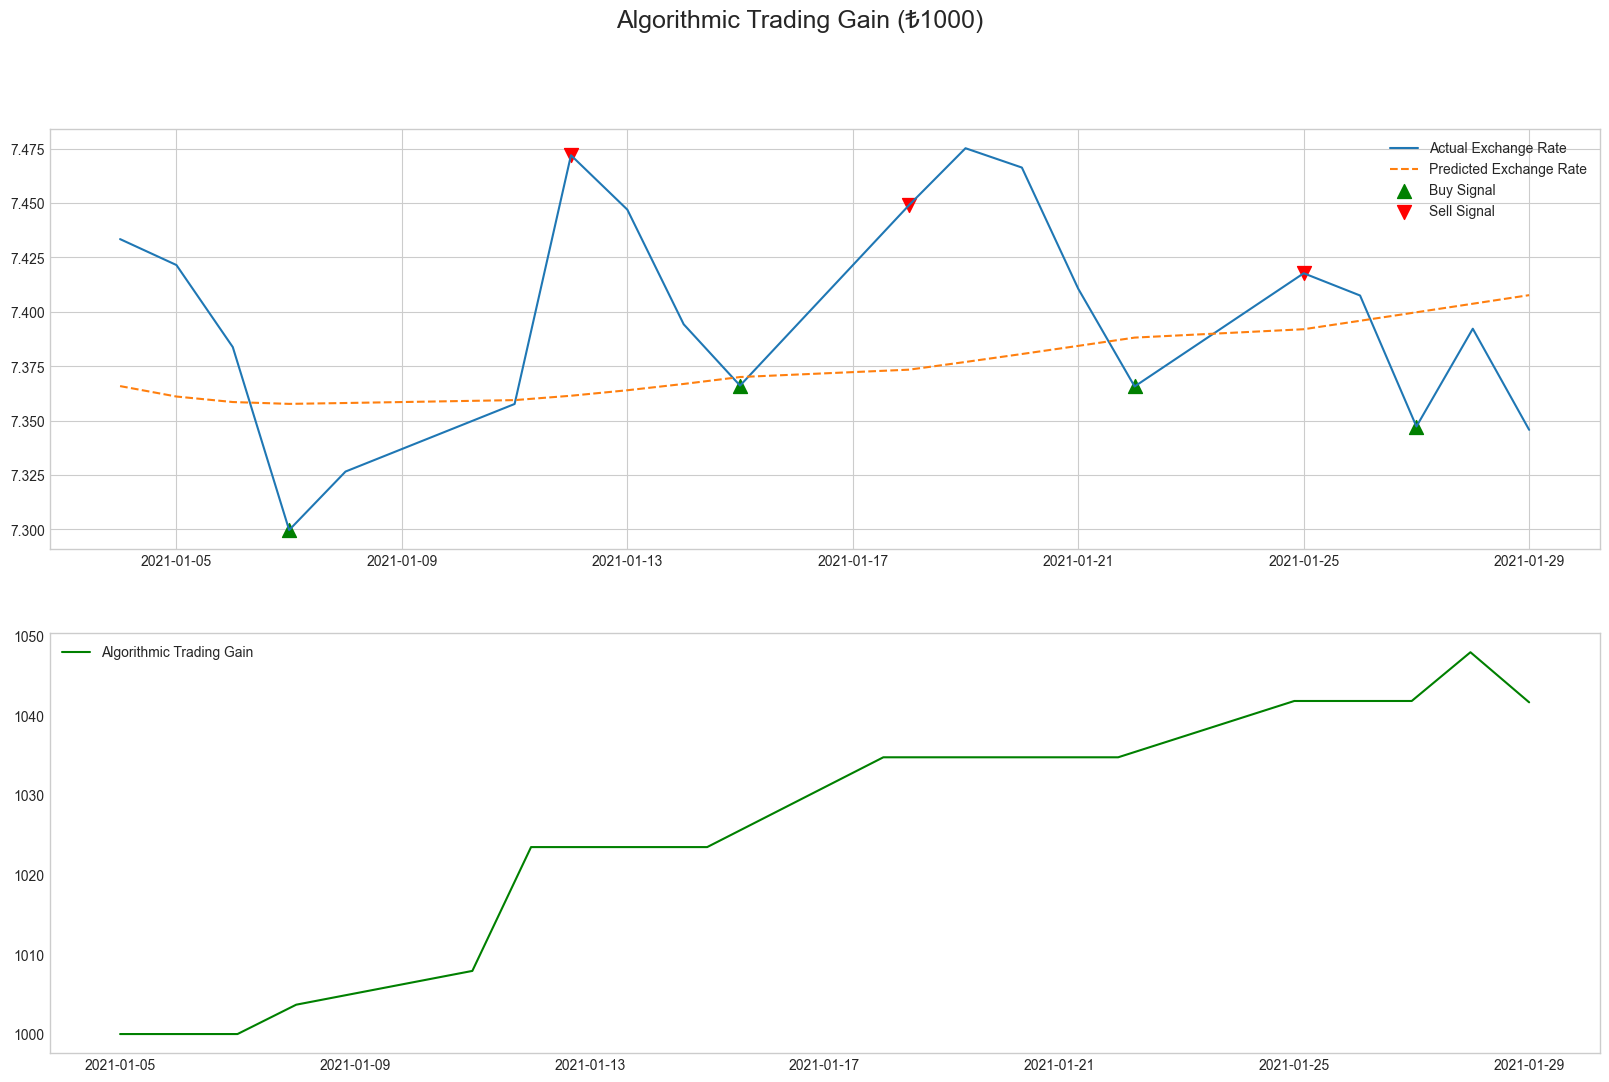

In [25]:
data["date"] = data.index

f,axarr = plt.subplots(2,figsize=(20,12),sharex=False)

f.suptitle("Algorithmic Trading Gain (₺1000)", fontsize=18)

axarr[0].plot(data["close"], label="Actual Exchange Rate")
axarr[0].plot(data["Predicted"], label="Predicted Exchange Rate",linestyle='--')

axarr[0].scatter(data[data["BUY_ind"] == 1]["date"].values, 
            data[data["BUY_ind"] == 1]["close"].values,
            marker="^", color="green", label="Buy Signal", s=100)

axarr[0].scatter(data[data["SELL_ind"] == 1]["date"].values,
            data[data["SELL_ind"] == 1]["close"].values,
            marker="v", color="red", label="Sell Signal", s=100)

axarr[0].legend(loc="best")
axarr[1].plot(data["Value"], label="Algorithmic Trading Gain",color="green")
axarr[1].grid()
axarr[1].legend(loc="best")
plt.show()
            

<b>It should be noted that in this simulation, we do not take into account the transaction cost, the trading difference and the taxes.<b>

# Graph : Confidence Interval, Actual and Estimated Values

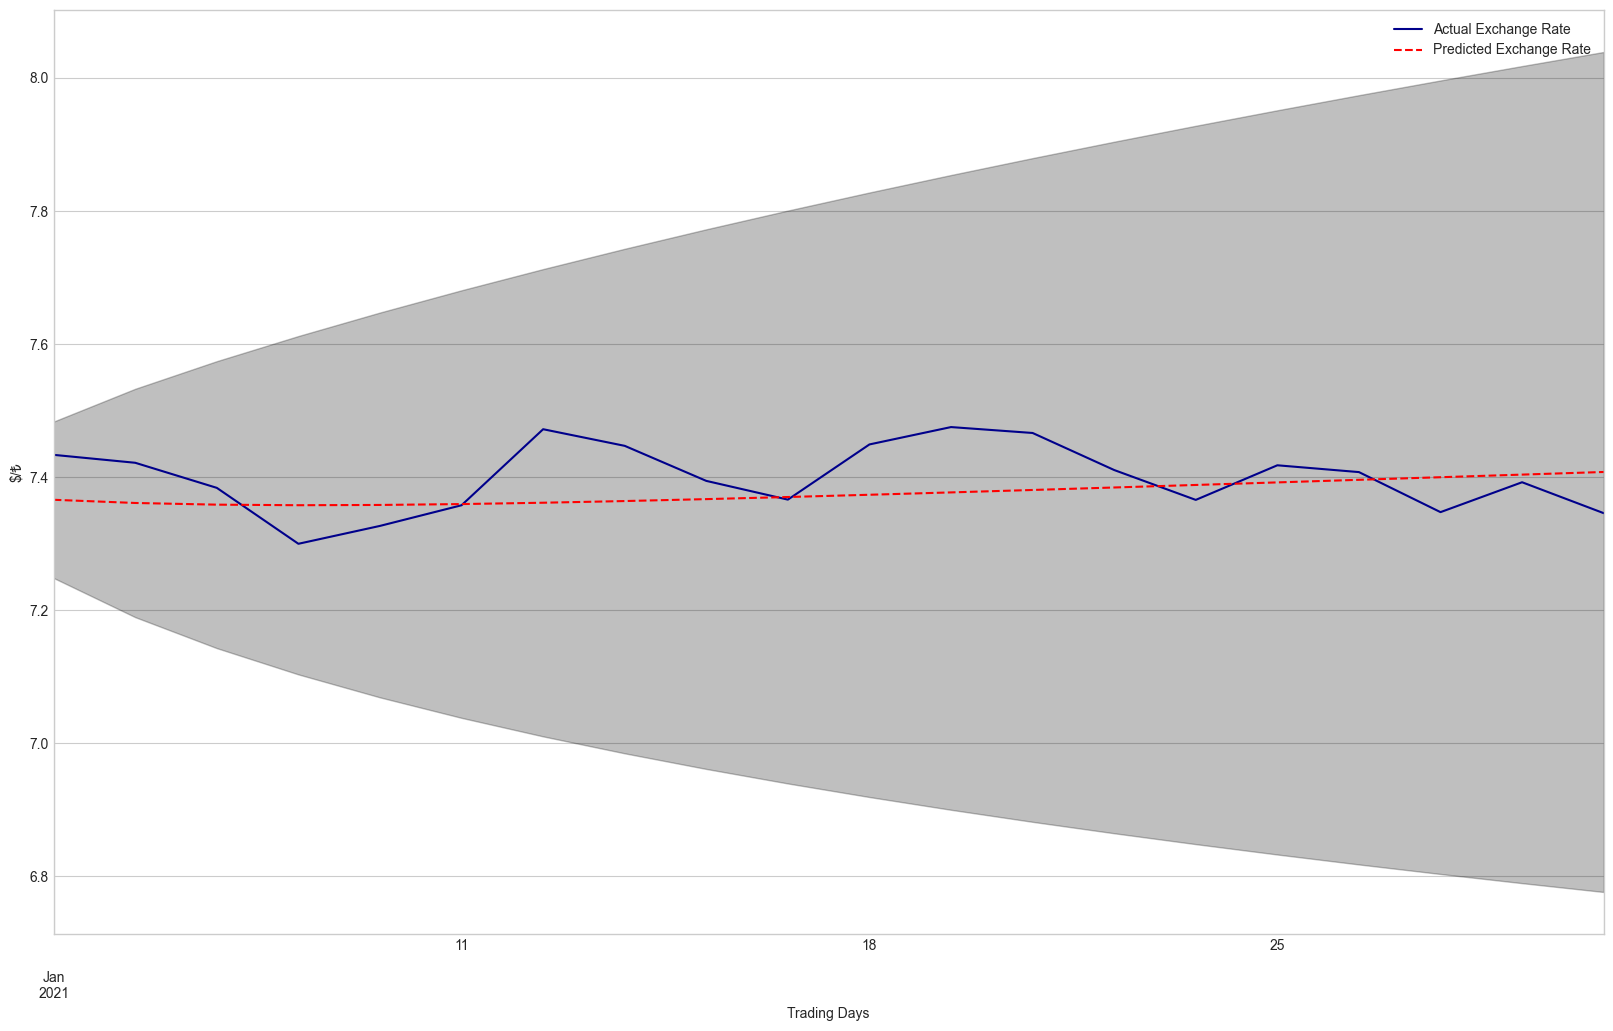

In [26]:
ax = data["close"].plot(figsize=(20,12),color="darkblue",label="Actual Exchange Rate")

data["Predicted"].plot(ax=ax,linestyle='--',color="red",label="Predicted Exchange Rate")

ax.fill_between(data["Predicted"].index, confint[:,0], confint[:,1], color='k', alpha=.25)

ax.set_xlabel("Trading Days")
ax.set_ylabel("$/₺")
ax.legend(loc="best")
plt.show()